In [1]:
from google.cloud import storage
import pandas as pd
import pyarrow.parquet as pq
import io
import ast

import koreanize_matplotlib

# 한글 깨짐 방지 (옵션)
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'  # Windows # 나눔고딕 가능
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 부호 깨짐 방지

In [2]:
client = storage.Client()

bucket_name = 'sprint_project4'
file_path = "sprint_project4/votes"

bucket = client.bucket(bucket_name)
blob = bucket.blob(file_path)

### 학급 테이블

In [3]:
blob = bucket.blob('votes/accounts_group.parquet')
parquet_bytes = blob.download_as_bytes()
group = pd.read_parquet(io.BytesIO(parquet_bytes))
group.head()

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


In [4]:
# grade와 class_num 이상치 제거
# group_df = group.copy()

group_df = group[(~group['grade'].isin([4,20])) & (~group['class_num'].isin([0,41]))]
group_df

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1
...,...,...,...,...
84510,84542,3,2,5107
84511,84543,2,7,3487
84512,84544,3,1,5043
84513,84545,2,7,416


In [5]:
id_school_df = group[['id', 'school_id']].copy()

### 학교 테이블

In [6]:
blob = bucket.blob('votes/accounts_school.parquet')
parquet_bytes = blob.download_as_bytes()
school = pd.read_parquet(io.BytesIO(parquet_bytes))
school.head()

,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,5,충청북도 충주시,160,M
2,6,충청북도 충주시,200,H
3,7,충청북도 충주시,114,H
4,8,충청북도 충주시,139,M


### 유저 테이블

## 12. accounts_user(유저)
- is_superuser : superuser 여부
- is_staff : staff 여부
- firebase_id : 과거 firebase 세션 관리 할 때 사용하는 식별자(이 컬럼은 제거 예정)
- friend_id_list : 친구 id 데이터
- block_user_id_list : 차단한 유저 id 데이터
- hide_user_id_list : 숨김 처리한 유저 id 데이터
- ban_status : 차단 혹은 탈퇴한 유저인지 타입
- report_count : 신고 당한 횟수
- alarm_count : 알람 갯수
- pending_chat: 안읽은 채팅 개수
- pending_votes : 확인 안한 투표 개수

In [7]:
blob = bucket.blob('votes/accounts_user.parquet')
parquet_bytes = blob.download_as_bytes()
user = pd.read_parquet(io.BytesIO(parquet_bytes))
user.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [8]:
# is_superuser, is_staff 값이 1인 row 제거 및 컬럼 제거

# 1. superuser와 is_staff =1인 행 제거
user =user[(user['is_superuser'] != 1) & (user['is_staff'] != 1)]

# 2. superuser와 is_staff 컬럼 제거
user = user.drop(columns=['is_superuser', 'is_staff'])
user.head()

,id,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
1,831962,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0
5,832614,M,1048,"[838541, 833041, 832151, 837806, 1437874, 1142...",1,2023-03-29 12:56:35.064406,[],[],N,0,28,0,14,12.0


In [9]:
user_df = user.copy()

# 사용 데이터 기간 5,6,7월
user_df = user[
    (user['created_at'].dt.year == 2023) &
    (user['created_at'].dt.month.isin([5, 6, 7]))
]
user_df.head()

,id,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
13302,855179,M,1358,"[849767, 850569, 857770, 856249, 850108, 869470]",1,2023-05-18 16:36:23.667542,[],[],N,0,1,0,23,5532.0
19094,862517,F,1391,"[880775, 838285, 868495, 875156, 838421, 83842...",1,2023-05-01 00:00:12.942200,[],[],N,0,1,0,19,6337.0
19095,862518,F,1063,"[857473, 846981, 860934, 858247, 859913, 86901...",1,2023-05-01 00:00:22.647793,[],[],N,0,0,0,61,7020.0
19096,862519,F,2137,"[1215494, 1150344, 1520776, 1160844, 1090445, ...",0,2023-05-01 00:00:32.161347,[],[],N,0,2,0,180,7392.0
19097,862520,M,2838,"[874368, 856706, 1407234, 982788, 1145859, 100...",1,2023-05-01 00:00:48.974195,[],[],N,0,1,0,190,3526.0


### 투표기록

## 13. accounts_userquestionrecord(투표기록)
- status : 상태(C : closed(닫힘), I : initial(초성 열림), B: blocked(차단))
- chosen_user_id : 선택 받은 유저 id
- opened_times : 열어본 횟수
- question_id : 질문 id
- question_piece_id : 투표 id
- answer_status : 답장 상태(N : 미답변, P : 비공개, A : 공개)
- answer_updated_at : 답장 시간
- report_count : 신고 횟수
- has_read : 읽었는지 여부

유령회원을 알아보자(기간을 나눠서 보자)

In [10]:
blob = bucket.blob('votes/accounts_userquestionrecord.parquet')
parquet_bytes = blob.download_as_bytes()
userquestionrecord = pd.read_parquet(io.BytesIO(parquet_bytes))
userquestionrecord.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


In [11]:
# 사용 데이터 기간 5,6,7월
userquestionrecord_df = userquestionrecord[
    (userquestionrecord['created_at'].dt.year == 2023) &
    (userquestionrecord['created_at'].dt.month.isin([5, 6, 7]))
]
userquestionrecord_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30798,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0
30799,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0
30800,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0
30801,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0
30802,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0


### 회원가입 유저들 중 투표한 유저 구하기(account_user, userquestionrecord)
- 10개 학교의 학생 데이터로만 분석
    - 투표율 재정의
        - 분모 : 10개 학교 학생들의 일별 누적 가입자 수
            - 탈퇴한 유저 제외 불가
        - 분자 : 10개 학교 학생들 중 일별 투표 참여 수

In [12]:
# 유저 투표 기록 => 4835명(5월~7월), 5074명
userquestionrecord_df.head()
print("투표 기록 존재하는 유니크 유저 수")
print(userquestionrecord_df['user_id'].nunique())

투표 기록 존재하는 유니크 유저 수
4835


In [13]:
# account_user에서 필요한 컬럼만 선택하고, id를 user_id로 변경
user_filtered = user[[
    'id', 'gender', 'is_push_on', 'ban_status', 
    'alarm_count', 'group_id', 'created_at'
]].rename(columns={'id': 'user_id', 'created_at':'user_created_at'})

user_filtered

# 2023년 7월 31일까지 필터링
user_filtered = user_filtered[user_filtered['user_created_at'] <= '2023-07-31']
user_filtered.head()

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at
1,831962,F,1,N,40878,12.0,2023-03-29 05:18:56.162368
2,832151,M,0,N,37,1.0,2023-03-29 12:56:34.989468
3,832340,F,1,N,19,1.0,2023-03-29 12:56:35.020790
4,832520,M,0,N,29,12.0,2023-03-29 12:56:35.049311
5,832614,M,1,N,28,12.0,2023-03-29 12:56:35.064406


In [14]:
# account_user와 userquestionrecord에 공통으로 존재하는 유저들 추출(id = user_id) -> 공통 존재 유저들의 학교id 알아내기 위해

# userquestionrecord에서 user_id 목록 추출 
voted_user_ids = userquestionrecord_df['user_id'].unique()

# user에서 해당 user_id만 추출
voted_user = user_filtered[user_filtered['user_id'].isin(voted_user_ids)]

# 결과 확인
print(voted_user.head())
print(f"투표 기록이 있는 유저 수: {voted_user['user_id'].nunique()}")

      user_id gender  is_push_on ban_status  alarm_count  group_id  \
396    838023      F           1          N            1     233.0   
633    838466      F           1          N            1     321.0   
1252   839357      M           1          N            1     519.0   
1889   840293      F           1          N            2     838.0   
2024   840473      M           1          N            0     915.0   

                user_created_at  
396  2023-04-19 09:06:00.719792  
633  2023-04-19 15:10:56.560337  
1252 2023-04-20 14:26:20.479856  
1889 2023-04-21 11:45:56.750174  
2024 2023-04-21 13:45:13.007506  
투표 기록이 있는 유저 수: 4835


In [15]:
# 학교 정보 group_id 기준 merge

# group 데이터에서 id → group_id로 이름 변경 (병합을 위해)
group_renamed = id_school_df.rename(columns={'id': 'group_id'})

# voted_user와 group_renamed 병합
voted_user = pd.merge(voted_user, group_renamed, on='group_id', how='left')
voted_user.head()

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at,school_id
0,838023,F,1,N,1,233.0,2023-04-19 09:06:00.719792,271
1,838466,F,1,N,1,321.0,2023-04-19 15:10:56.560337,369
2,839357,M,1,N,1,519.0,2023-04-20 14:26:20.479856,271
3,840293,F,1,N,2,838.0,2023-04-21 11:45:56.750174,369
4,840473,M,1,N,0,915.0,2023-04-21 13:45:13.007506,369


In [16]:
# school_id 추출
school_ids = voted_user['school_id'].unique()

# ② school_id를 DataFrame으로 변환
voted_school_id = pd.DataFrame({'school_id': school_ids})
voted_school_id

,school_id
0,271
1,369
2,5491
3,352
4,4516
5,4426
6,1478
7,5520
8,5372
9,1719


In [17]:
# 7월까까지 필터링한 user 데이터에 학교 정보 추가

# group 테이블에서 id → group_id로 이름 변경
group_renamed = id_school_df.rename(columns={'id': 'group_id'})

# user_filtered와 group_renamed 병합
user_school_info = pd.merge(user_filtered, group_renamed, on='group_id', how='left')
user_school_info.head()

,user_id,gender,is_push_on,ban_status,alarm_count,group_id,user_created_at,school_id
0,831962,F,1,N,40878,12.0,2023-03-29 05:18:56.162368,1.0
1,832151,M,0,N,37,1.0,2023-03-29 12:56:34.989468,1.0
2,832340,F,1,N,19,1.0,2023-03-29 12:56:35.020790,1.0
3,832520,M,0,N,29,12.0,2023-03-29 12:56:35.049311,1.0
4,832614,M,1,N,28,12.0,2023-03-29 12:56:35.064406,1.0


In [18]:
#  투표한 학생들이 존재하는 학교에 해당하는 유저들 추출
user_school_info = user_school_info[user_school_info['school_id'].notna()].copy()

# school_id 컬럼 int로 
voted_school_id['school_id'] = voted_school_id['school_id'].astype(int)
user_school_info['school_id'] = user_school_info['school_id'].astype(int)

# 필터링: voted_school_id에 있는 school_id만 남기기
user_school_info = user_school_info[user_school_info['school_id'].isin(voted_school_id['school_id'])]

# 유저 투표 기록 => 4835명(5월~7월), 5074명
print(f"투표기록이 있는 학생들이 속한 학교 유니크 회원가입 유저 수: {user_school_info.shape[0]}")
print(f"투표 기록 존재하는 유니크 유저 수 : {userquestionrecord_df['user_id'].nunique()}")

투표기록이 있는 학생들이 속한 학교 유니크 회원가입 유저 수: 5074
투표 기록 존재하는 유니크 유저 수 : 4835


## kpi 구하기

#### 1. 일별 누적 회원 가입수 

In [19]:
# 1. 날짜만 추출
user_school_info['user_date'] = user_school_info['user_created_at'].dt.date

# 2. 전체 날짜 범위: 실제 시작 ~ 7월 31일
full_user_date_range = pd.DataFrame({
    'user_date': pd.date_range(
        start=user_school_info['user_date'].min(),
        end=pd.to_datetime('2023-07-31')
    ).date
})

# 3. 일별 회원가입자 수
daily_user = (
    user_school_info.groupby('user_date')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'daily_user_count'})
)

# 4. 병합 후 가입 없는 날은 0으로
daily_user_complete = pd.merge(full_user_date_range, daily_user, on='user_date', how='left').fillna(0)
daily_user_complete['daily_user_count'] = daily_user_complete['daily_user_count'].astype(int)

# 5. 누적 가입자 수
daily_user_complete['cumulative_user_count'] = daily_user_complete['daily_user_count'].cumsum()

# 6. 5월 1일부터만 필터링
daily_user_filtered = daily_user_complete[
    daily_user_complete['user_date'] >= pd.to_datetime('2023-05-01').date()
]

# 7. DataFrame 분리
daily_user = daily_user_filtered[['user_date', 'daily_user_count']].copy()
cumulative_user = daily_user_filtered[['user_date', 'cumulative_user_count']].copy()

# 결과 확인
print("일별 회원 가입자 수")
display(daily_user)
print("일별 누적 회원 가입자 수")
display(cumulative_user)

일별 회원 가입자 수


,user_date,daily_user_count
12,2023-05-01,43
13,2023-05-02,99
14,2023-05-03,389
15,2023-05-04,184
16,2023-05-05,434
...,...,...
99,2023-07-27,0
100,2023-07-28,0
101,2023-07-29,0
102,2023-07-30,0


일별 누적 회원 가입자 수


,user_date,cumulative_user_count
12,2023-05-01,446
13,2023-05-02,545
14,2023-05-03,934
15,2023-05-04,1118
16,2023-05-05,1552
...,...,...
99,2023-07-27,5074
100,2023-07-28,5074
101,2023-07-29,5074
102,2023-07-30,5074


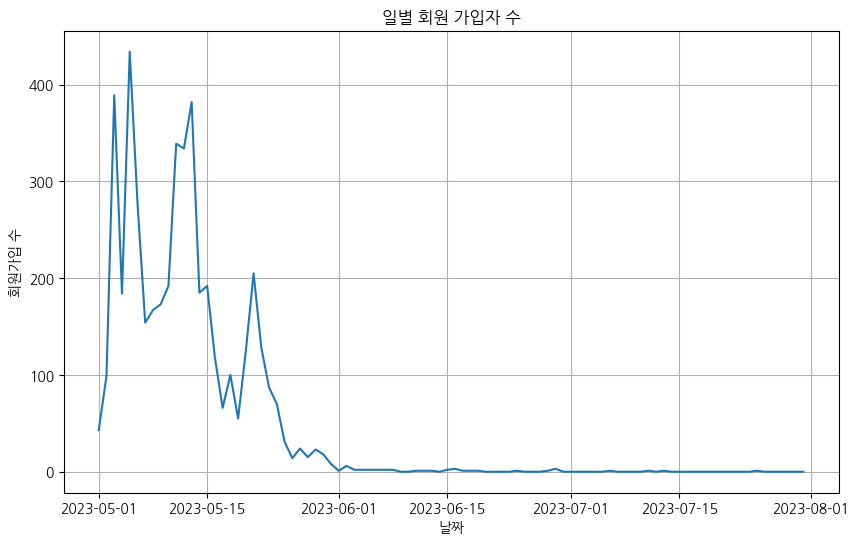

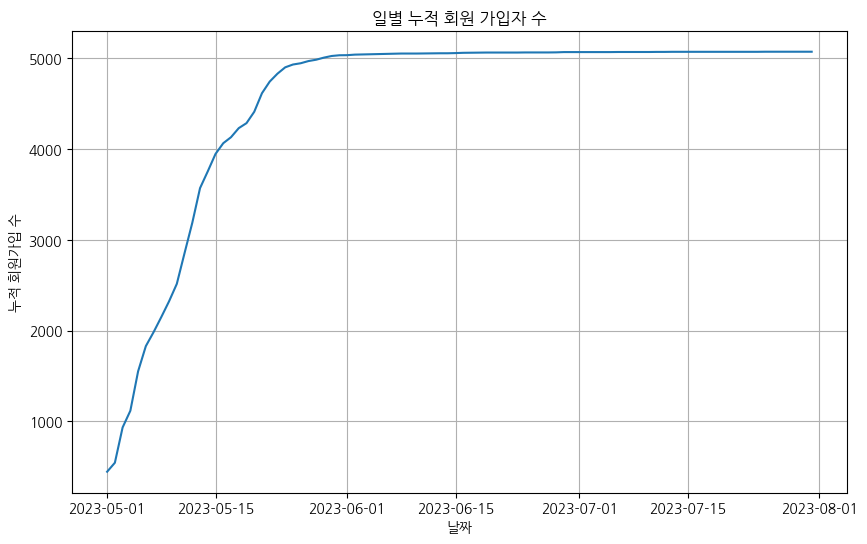

In [20]:
# 일별 회원가입자 수
plt.figure(figsize = (10,6))
sns.lineplot(data = daily_user, x = 'user_date', y = 'daily_user_count')
plt.title("일별 회원 가입자 수")
plt.xlabel('날짜')
plt.ylabel("회원가입 수")
plt.grid()
plt.show()


# 일별 누적 회원가입자 수
plt.figure(figsize = (10,6))
sns.lineplot(data = cumulative_user, x = 'user_date', y = 'cumulative_user_count')
plt.title("일별 누적 회원 가입자 수")
plt.xlabel('날짜')
plt.ylabel("누적 회원가입 수")
plt.grid()
plt.show()

### 2. 일별 투표 유저 수

In [21]:
questionrecord_df = userquestionrecord_df.copy()

# 1. 날짜만 추출
questionrecord_df['vote_date'] = questionrecord_df['created_at'].dt.date

# 2. 일별 고유 유저 수 집계
daily_vote = (
    questionrecord_df.groupby('vote_date')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'daily_vote_count'})
)

# 3. 5월 1일 이후만 필터링
daily_vote = daily_vote[daily_vote['vote_date'] >= pd.to_datetime('2023-05-01').date()]
daily_vote

,vote_date,daily_vote_count
0,2023-05-01,325
1,2023-05-02,413
2,2023-05-03,756
3,2023-05-04,820
4,2023-05-05,1248
...,...,...
87,2023-07-27,14
88,2023-07-28,14
89,2023-07-29,17
90,2023-07-30,11


### 3. 누적 회원가입 유저 데이터 + 일별 투표 유저 데이터 merge

In [22]:
# 날짜 컬럼 이름을 통일
daily_vote_renamed = daily_vote.rename(columns={'vote_date': 'date'})
cumulative_user_renamed = cumulative_user.rename(columns={'user_date': 'date'})

# 날짜 기준 병합
ratio_df = pd.merge(daily_vote_renamed, cumulative_user_renamed, on='date', how='outer')

# 날짜 정렬
ratio_df = ratio_df.sort_values(by='date').reset_index(drop=True)
ratio_df

,date,daily_vote_count,cumulative_user_count
0,2023-05-01,325,446
1,2023-05-02,413,545
2,2023-05-03,756,934
3,2023-05-04,820,1118
4,2023-05-05,1248,1552
...,...,...,...
87,2023-07-27,14,5074
88,2023-07-28,14,5074
89,2023-07-29,17,5074
90,2023-07-30,11,5074


In [23]:
# 날짜별 투표율 계산
ratio_df['vote_rate'] = (ratio_df['daily_vote_count'] / ratio_df['cumulative_user_count']) * 100

# 소수점 2자리까지 반올림
ratio_df['vote_rate'] = ratio_df['vote_rate'].round(2)
ratio_df[['date', 'daily_vote_count', 'cumulative_user_count', 'vote_rate']]

,date,daily_vote_count,cumulative_user_count,vote_rate
0,2023-05-01,325,446,72.87
1,2023-05-02,413,545,75.78
2,2023-05-03,756,934,80.94
3,2023-05-04,820,1118,73.35
4,2023-05-05,1248,1552,80.41
...,...,...,...,...
87,2023-07-27,14,5074,0.28
88,2023-07-28,14,5074,0.28
89,2023-07-29,17,5074,0.34
90,2023-07-30,11,5074,0.22


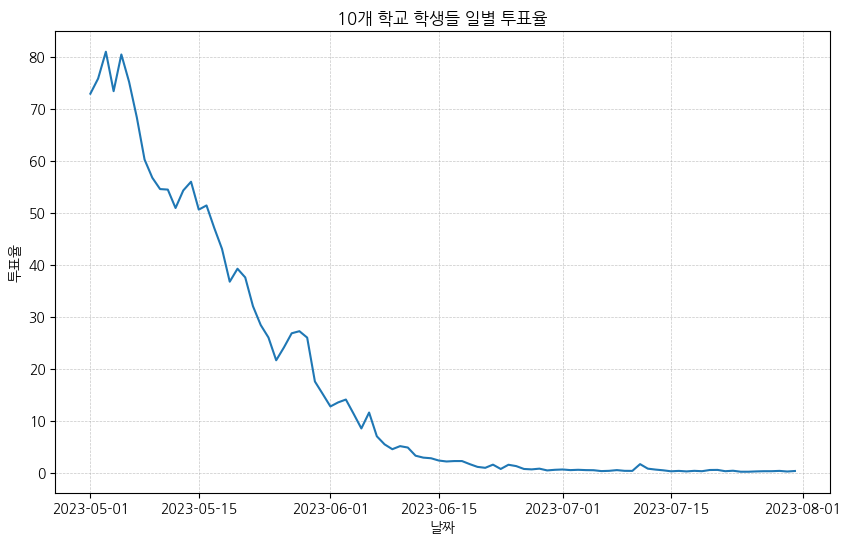

In [24]:
# 10개 학교 유저들 일별 투표율
plt.figure(figsize = (10,6))
sns.lineplot(data = ratio_df, x = 'date', y = 'vote_rate')
plt.title("10개 학교 학생들 일별 투표율")
plt.xlabel('날짜')
plt.ylabel('투표율')
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

## 투표한 유저들의 리텐션

In [25]:
userquestionrecord_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30798,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0
30799,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0
30800,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0
30801,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0
30802,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0


In [26]:
# 투표 날짜 컬럼 년-월-일로 생성
userquestionrecord_df = userquestionrecord_df.copy()
userquestionrecord_df['vote_date'] = userquestionrecord_df['created_at'].dt.date

In [27]:
userquestionrecord_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,vote_date
30798,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0,2023-05-01
30799,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0,2023-05-01
30800,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0,2023-05-01
30801,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0,2023-05-01
30802,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0,2023-05-01


In [28]:
# 각 유저별 일별 투표 수 및 순서(투표 순서)

#  유저별 + 날짜별 투표 수 집계
user_daily_vote_df = (
    userquestionrecord_df
    .groupby(['user_id', 'vote_date'])
    .size()
    .reset_index(name='daily_vote_count')
)
# 유저별 투표 날짜 순 정렬
user_daily_vote_df = user_daily_vote_df.sort_values(['user_id', 'vote_date'])

# 유저별로 투표 순서 번호 붙이기
user_daily_vote_df['vote_sequence'] = (
    user_daily_vote_df
    .groupby('user_id')
    .cumcount() + 1  # 0부터 시작하므로 +1
)

user_daily_vote_df

,user_id,vote_date,daily_vote_count,vote_sequence
0,838023,2023-05-02,1,1
1,838023,2023-05-03,10,2
2,838023,2023-05-04,4,3
3,838466,2023-05-02,9,1
4,838466,2023-05-03,34,2
...,...,...,...,...
49569,1579418,2023-07-25,9,1
49570,1579418,2023-07-26,17,2
49571,1579418,2023-07-28,7,3
49572,1579418,2023-07-29,7,4


In [29]:
# 1. first_vote_date 기준으로 코호트 날짜 설정(유저별로 첫 투표 날짜(min))
vote_df = user_daily_vote_df.copy()
vote_df['first_vote_date'] = vote_df.groupby('user_id')['vote_date'].transform('min')

# 2. 가입일 기준 n일차 계산(첫날은 0일)
vote_df['day_n'] = (pd.to_datetime(vote_df['vote_date']) - pd.to_datetime(vote_df['first_vote_date'])).dt.days

# 3. 유저 수 집계 (코호트일, day_n 기준으로 몇 명이 활동했는가)
cohort_table = (
    vote_df
    .groupby(['first_vote_date', 'day_n'])['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'active_users'})
)

# 4. 코호트별 전체 유저 수 (Day 0 기준 유입자 수(해당 날짜가 첫 투표일임))
cohort_sizes = (
    cohort_table[cohort_table['day_n'] == 0]
    .rename(columns={'active_users': 'cohort_size'})[['first_vote_date', 'cohort_size']]
)

# 5. 병합하여 리텐션율 계산
cohort_table = cohort_table.merge(cohort_sizes, on='first_vote_date')
cohort_table['retention_rate'] = (cohort_table['active_users'] / cohort_table['cohort_size'] * 100).round(2)

# 6. 피벗 테이블 변환
cohort_retention = cohort_table.pivot(index='first_vote_date', columns='day_n', values='retention_rate').fillna(0)

# 7. 각 코호트별 투표 유저 수 추가


In [30]:
# 6월 첫째주까지 남은 피봇 다시 생성하기
cohort_retention

day_n,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-05-01,100.0,95.38,87.69,70.15,70.46,68.31,60.00,47.38,39.38,36.31,...,0.00,0.62,0.00,1.23,0.62,0.31,0.92,0.92,0.62,1.23
2023-05-02,100.0,80.58,71.84,68.93,67.96,59.22,45.63,43.69,45.63,33.98,...,0.00,0.00,0.97,0.97,0.00,0.00,1.94,0.00,0.97,0.00
2023-05-03,100.0,90.21,91.75,87.37,81.70,68.04,60.57,50.00,42.01,33.25,...,0.52,0.00,0.52,0.00,0.00,0.00,0.00,0.77,0.00,0.00
2023-05-04,100.0,92.86,90.48,83.93,63.69,55.36,49.40,42.26,33.33,23.81,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-05-05,100.0,93.81,85.78,75.92,59.40,56.88,43.81,37.61,31.65,33.49,...,0.23,0.00,0.23,0.00,0.23,0.00,0.00,0.00,0.00,0.00
2023-05-06,100.0,88.52,81.42,71.04,57.38,54.10,38.25,35.52,32.79,24.59,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-05-07,100.0,89.52,73.33,72.38,55.24,50.48,55.24,43.81,39.05,35.24,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-05-08,100.0,80.54,77.85,83.89,66.44,61.07,61.74,50.34,48.99,40.27,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-05-09,100.0,91.34,88.74,83.12,84.42,83.98,76.19,72.73,73.16,64.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [47]:
#  cohort_sizes의 first_vote_date 데이터 타입 변환
cohort_sizes['first_vote_date'] = pd.to_datetime(cohort_sizes['first_vote_date'])

# 1. cohort_retention의 index도 datetime 형식으로 재확인
cohort_retention.index = pd.to_datetime(cohort_retention.index)

# 2. cohort_sizes를 index로 변환
cohort_sizes_indexed = cohort_sizes.set_index('first_vote_date')

# 3. 정확히 병합 (index 기준)
retention = pd.concat([cohort_retention, cohort_sizes_indexed], axis=1)

# 4. 날짜 컬럼 순서 정리
day_cols = sorted([col for col in retention.columns if isinstance(col, int)])
final_cols = ['cohort_size'] + day_cols
retention = retention[final_cols]


In [ ]:

retention

,cohort_size,0,1,2,3,4,5,6,7,8,...,82,83,84,85,86,87,88,89,90,91
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-05-01,325,100.0,95.38,87.69,70.15,70.46,68.31,60.00,47.38,39.38,...,0.00,0.62,0.00,1.23,0.62,0.31,0.92,0.92,0.62,1.23
2023-05-02,103,100.0,80.58,71.84,68.93,67.96,59.22,45.63,43.69,45.63,...,0.00,0.00,0.97,0.97,0.00,0.00,1.94,0.00,0.97,0.00
2023-05-03,388,100.0,90.21,91.75,87.37,81.70,68.04,60.57,50.00,42.01,...,0.52,0.00,0.52,0.00,0.00,0.00,0.00,0.77,0.00,0.00
2023-05-04,168,100.0,92.86,90.48,83.93,63.69,55.36,49.40,42.26,33.33,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-05-05,436,100.0,93.81,85.78,75.92,59.40,56.88,43.81,37.61,31.65,...,0.23,0.00,0.23,0.00,0.23,0.00,0.00,0.00,0.00,0.00
2023-05-06,183,100.0,88.52,81.42,71.04,57.38,54.10,38.25,35.52,32.79,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-05-07,105,100.0,89.52,73.33,72.38,55.24,50.48,55.24,43.81,39.05,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-05-08,149,100.0,80.54,77.85,83.89,66.44,61.07,61.74,50.34,48.99,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2023-05-09,231,100.0,91.34,88.74,83.12,84.42,83.98,76.19,72.73,73.16,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [54]:
# 1. first_vote_date가 5월 25일 이하인 것만 필터
retention = retention[retention.index <= '2023-05-25']

# 2. day_n이 30 이하인 컬럼만 남기기
filtered_day_cols = [col for col in day_cols if col <= 30]
final_cols = ['cohort_size'] + filtered_day_cols
retention = retention[final_cols]

In [55]:
retention

,cohort_size,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-05-01,325,100.0,95.38,87.69,70.15,70.46,68.31,60.00,47.38,39.38,...,10.15,8.31,11.69,10.15,13.23,15.38,16.92,17.85,9.85,7.69
2023-05-02,103,100.0,80.58,71.84,68.93,67.96,59.22,45.63,43.69,45.63,...,14.56,9.71,9.71,8.74,16.50,16.50,18.45,11.65,6.80,3.88
2023-05-03,388,100.0,90.21,91.75,87.37,81.70,68.04,60.57,50.00,42.01,...,7.73,5.93,7.99,12.63,13.66,14.43,9.54,7.99,6.70,10.82
2023-05-04,168,100.0,92.86,90.48,83.93,63.69,55.36,49.40,42.26,33.33,...,5.36,6.55,10.12,6.55,7.74,4.17,3.57,3.57,8.33,2.98
2023-05-05,436,100.0,93.81,85.78,75.92,59.40,56.88,43.81,37.61,31.65,...,8.03,13.76,13.07,13.07,6.88,6.42,5.50,8.49,6.42,4.82
2023-05-06,183,100.0,88.52,81.42,71.04,57.38,54.10,38.25,35.52,32.79,...,13.66,6.56,8.74,6.01,8.20,2.19,6.01,4.37,3.28,4.37
2023-05-07,105,100.0,89.52,73.33,72.38,55.24,50.48,55.24,43.81,39.05,...,21.90,14.29,10.48,9.52,5.71,10.48,6.67,8.57,7.62,9.52
2023-05-08,149,100.0,80.54,77.85,83.89,66.44,61.07,61.74,50.34,48.99,...,28.86,15.44,17.45,16.11,13.42,14.77,15.44,9.40,13.42,8.05
2023-05-09,231,100.0,91.34,88.74,83.12,84.42,83.98,76.19,72.73,73.16,...,19.91,14.29,14.29,16.02,16.88,18.18,12.55,16.88,8.66,8.23


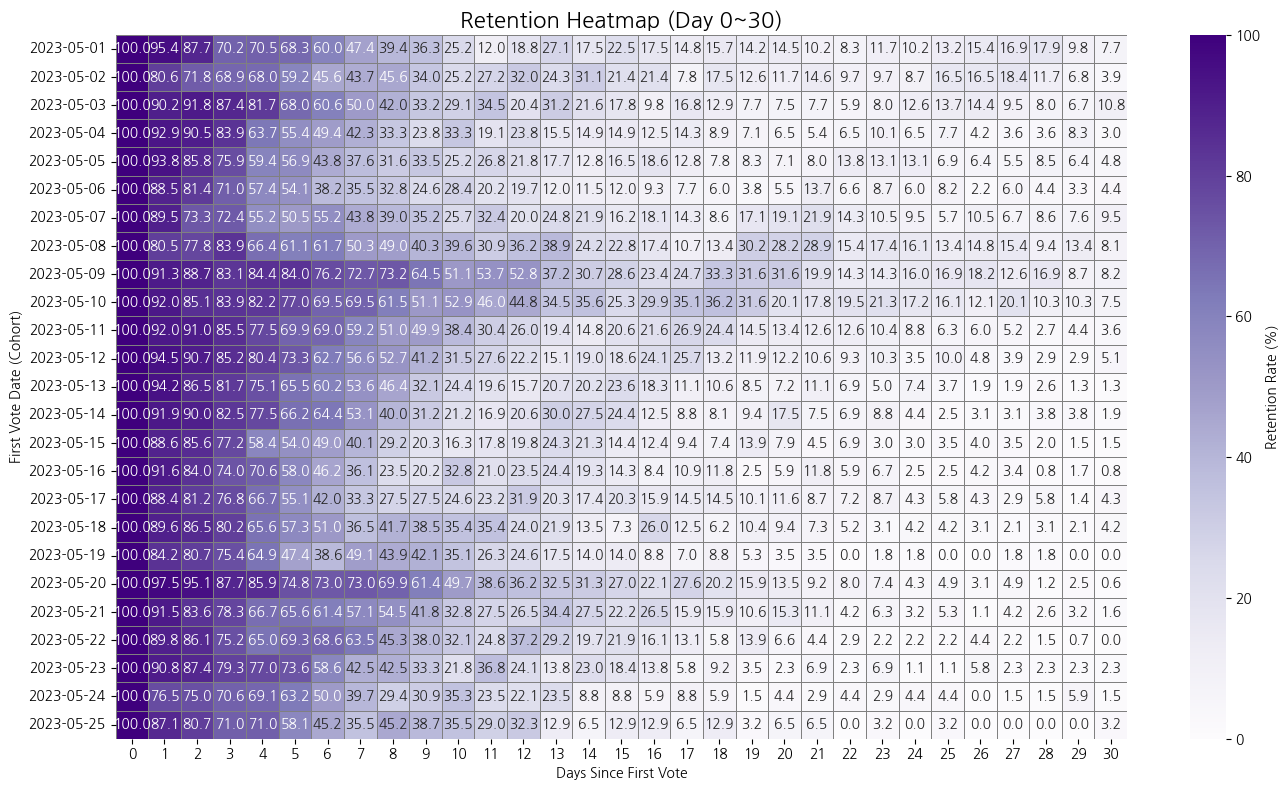

In [60]:
# 히트맵 대상: cohort_size 제외한 day_n 컬럼만 선택
heatmap_data = retention.drop(columns='cohort_size')

# 인덱스를 날짜 문자열로 변환 (시간 제거)
heatmap_data.index = heatmap_data.index.strftime('%Y-%m-%d')

# 히트맵 그리기
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".1f", cmap="Purples", linewidths=0.5, linecolor='gray',
    cbar_kws={'label': 'Retention Rate (%)'}
)

plt.title('Retention Heatmap (Day 0~30)', fontsize=16)
plt.xlabel('Days Since First Vote')
plt.ylabel('First Vote Date (Cohort)')
plt.tight_layout()
plt.show()

In [33]:
vote_df

,user_id,vote_date,daily_vote_count,vote_sequence,first_vote_date,day_n
0,838023,2023-05-02,1,1,2023-05-02,0
1,838023,2023-05-03,10,2,2023-05-02,1
2,838023,2023-05-04,4,3,2023-05-02,2
3,838466,2023-05-02,9,1,2023-05-02,0
4,838466,2023-05-03,34,2,2023-05-02,1
...,...,...,...,...,...,...
49569,1579418,2023-07-25,9,1,2023-07-25,0
49570,1579418,2023-07-26,17,2,2023-07-25,1
49571,1579418,2023-07-28,7,3,2023-07-25,3
49572,1579418,2023-07-29,7,4,2023-07-25,4


In [34]:
cohort_table

,first_vote_date,day_n,active_users,cohort_size,retention_rate
0,2023-05-01,0,325,325,100.00
1,2023-05-01,1,310,325,95.38
2,2023-05-01,2,285,325,87.69
3,2023-05-01,3,228,325,70.15
4,2023-05-01,4,229,325,70.46
...,...,...,...,...,...
1711,2023-07-25,0,1,1,100.00
1712,2023-07-25,1,1,1,100.00
1713,2023-07-25,3,1,1,100.00
1714,2023-07-25,4,1,1,100.00


In [35]:
# 각 날짜별 첫날 투표 유저 수
cohort_sizes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, 0 to 1711
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   first_vote_date  53 non-null     datetime64[ns]
 1   cohort_size      53 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.2 KB


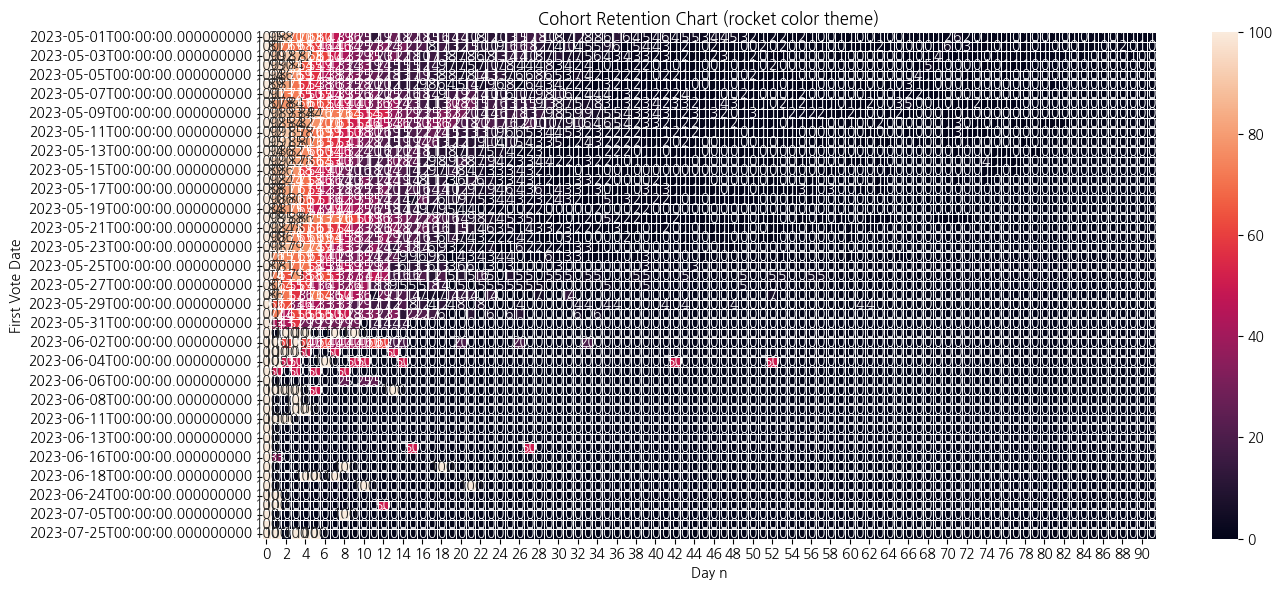

In [36]:
plt.figure(figsize=(14, 6))
sns.heatmap(
    cohort_retention,
    annot=True,
    fmt=".0f",       # 정수만 표시
    cmap="rocket",   # ← 여기!
    linewidths=0.5,
    linecolor='white',
    cbar=True
)
plt.title('Cohort Retention Chart (rocket color theme)')
plt.xlabel('Day n')
plt.ylabel('First Vote Date')
plt.tight_layout()
plt.show()

### 어떤 코호트의 그룹의 리텐션을 볼 것인지

In [37]:
# 6월 12일 이전 일주일, 이후 일주일 그룹의 리텐션비교
before_start = pd.to_datetime("2023-06-05")
before_end = pd.to_datetime("2023-06-11")
after_start = pd.to_datetime("2023-06-12")
after_end = pd.to_datetime("2023-06-18")

In [38]:
cohort_retention.index = pd.to_datetime(cohort_retention.index)

before_cohort = cohort_retention[(cohort_retention.index >= before_start) & (cohort_retention.index <= before_end)]
after_cohort = cohort_retention[(cohort_retention.index >= after_start) & (cohort_retention.index <= after_end)]


#### 6월 12일 전후 리텐션은 무의미하다

In [39]:
before_cohort

day_n,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-06-05,100.0,50.0,0.0,50.0,0.0,50.0,0.0,0.0,50.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-06,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-07,100.0,100.0,100.0,100.0,0.0,50.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-08,100.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-10,100.0,0.0,0.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-11,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
after_cohort

day_n,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
first_vote_date,,,,,,,,,,,,,,,,,,,,,
2023-06-12,100.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-13,100.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-15,100.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-16,100.0,33.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-17,100.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06-18,100.0,0.00,0.0,0.0,100.0,100.0,0.0,100.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 리텐션하다가 잘못된 길로 간 결과

In [41]:
# 재투표인 사람들 확인하기
repeat_vote = user_daily_vote_df[user_daily_vote_df['vote_sequence'] > 1]
display(repeat_vote)

# 재투표한 유저 수
print(f"재투표 진행 유니크 유저 수 : {repeat_vote['user_id'].nunique()}")

# 전체 투표 기록 유저수 
print(f"투표 진행 유니크 유저 수 : {questionrecord_df['user_id'].nunique()}")

# 5월 ~ 7월 투표 진행 유저 중 재투표 유저 비율
repeat_vote_rate = round(
    (repeat_vote['user_id'].nunique() / questionrecord_df['user_id'].nunique()) * 100,
    2)
print(f"5월 ~ 7월 투표 진행 유저 중 1번이라도 재투표 유저 비율 : {repeat_vote_rate}%")

,user_id,vote_date,daily_vote_count,vote_sequence
1,838023,2023-05-03,10,2
2,838023,2023-05-04,4,3
4,838466,2023-05-03,34,2
5,838466,2023-05-04,34,3
6,838466,2023-05-05,33,4
...,...,...,...,...
49567,1577440,2023-06-30,4,2
49570,1579418,2023-07-26,17,2
49571,1579418,2023-07-28,7,3
49572,1579418,2023-07-29,7,4


재투표 진행 유니크 유저 수 : 4681
투표 진행 유니크 유저 수 : 4835
5월 ~ 7월 투표 진행 유저 중 1번이라도 재투표 유저 비율 : 96.81%


In [42]:
# 필요 없음
repeat_vote = repeat_vote.copy()

repeat_vote['month'] = pd.to_datetime(repeat_vote['vote_date']).dt.to_period('M')

# 4. 월별 재투표 유저 수 집계
monthly_repeat_vote = (
    repeat_vote
    .groupby('month')['user_id']
    .nunique()
    .reset_index(name='repeat_voter_count')
)

# 월별 재투표 유저 수
monthly_repeat_vote

,month,repeat_voter_count
0,2023-05,4638
1,2023-06,1863
2,2023-07,387


In [43]:
# 1. 재투표 유저 필터링
repeat_votes = user_daily_vote_df[user_daily_vote_df['vote_sequence'] >= 2]

# 2. 일자별 재투표 유저 수 집계
daily_repeat_count = (
    repeat_votes
    .groupby('vote_date')['user_id']
    .nunique()
    .reset_index(name='repeat_voter_count')
)

# 3. 전체 날짜 생성 (5월 1일 ~ 7월 31일)
all_dates = pd.date_range(start='2023-05-01', end='2023-07-31')
all_dates_df = pd.DataFrame({'vote_date': all_dates.date})

# 4. 전체 날짜 기준으로 merge → 없는 날짜는 0으로
daily_repeat_count = pd.merge(
    all_dates_df,
    daily_repeat_count,
    on='vote_date',
    how='left'
).fillna({'repeat_voter_count': 0})

# 5. 정수형 변환
daily_repeat_count['repeat_voter_count'] = daily_repeat_count['repeat_voter_count'].astype(int)
daily_repeat_count

,vote_date,repeat_voter_count
0,2023-05-01,0
1,2023-05-02,310
2,2023-05-03,368
3,2023-05-04,652
4,2023-05-05,812
...,...,...
87,2023-07-27,14
88,2023-07-28,14
89,2023-07-29,17
90,2023-07-30,11


In [44]:
# 'date' 컬럼과 'vote_date' 컬럼 이름 맞추기
ratio_df = ratio_df.rename(columns={'date': 'vote_date'})

# 병합
vote_with_repeat = pd.merge(
    daily_repeat_count,  
    ratio_df,  # 재투표 유저 수 포함 데이터
    on='vote_date',
    how='left'
)
# 컬럼명 설명
# vote_date : 투표 이루어진 날짜
# repeat_voter_count : 재투표한 유저 수
# daily_vote_count : 일별 투표 유저 수
# cumulative_user_count : 누적 회원가입 유저 수
# vote_rate : 일별 투표 유저 수 / 누적 회원가입 유저 수
vote_with_repeat.head()

,vote_date,repeat_voter_count,daily_vote_count,cumulative_user_count,vote_rate
0,2023-05-01,0,325,446,72.87
1,2023-05-02,310,413,545,75.78
2,2023-05-03,368,756,934,80.94
3,2023-05-04,652,820,1118,73.35
4,2023-05-05,812,1248,1552,80.41


In [45]:
# 재투표율 계산 : 해당일 재투표 유저 수 / 해당일 투표 유저 수
# 재투표율 계산 후 새로운 컬럼으로 추가
vote_with_repeat['repeat_vote_rate'] = (
    vote_with_repeat['repeat_voter_count'] / vote_with_repeat['daily_vote_count'] * 100
).round(2)  

In [46]:
# 5,6,7월 종합적 투표 계산 데이터 프레임
vote_with_repeat

,vote_date,repeat_voter_count,daily_vote_count,cumulative_user_count,vote_rate,repeat_vote_rate
0,2023-05-01,0,325,446,72.87,0.00
1,2023-05-02,310,413,545,75.78,75.06
2,2023-05-03,368,756,934,80.94,48.68
3,2023-05-04,652,820,1118,73.35,79.51
4,2023-05-05,812,1248,1552,80.41,65.06
...,...,...,...,...,...,...
87,2023-07-27,14,14,5074,0.28,100.00
88,2023-07-28,14,14,5074,0.28,100.00
89,2023-07-29,17,17,5074,0.34,100.00
90,2023-07-30,11,11,5074,0.22,100.00
